In [1]:
import cv2
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        img = cv2.imread(os.path.join(dirname, filename))
        if img is not None:
            print(img.shape)
            break

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0025701.jpg
(450, 600, 3)
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025701.jpg
(450, 600, 3)
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0030066.jpg
(450, 600, 3)
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030066.jpg
(450, 600, 3)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    train_path = 'train_dir2'
    valid_path = 'val_dir2'
    test_path= 'testing_dir2'
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [4]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
skin_df = pd.read_csv("../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [6]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2


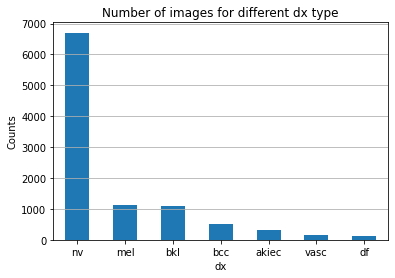

In [7]:
skin_df['dx'].value_counts().plot.bar(rot=0)
plt.title('Number of images for different dx type')
plt.xlabel('dx')
plt.ylabel('Counts')
plt.grid(axis='y')

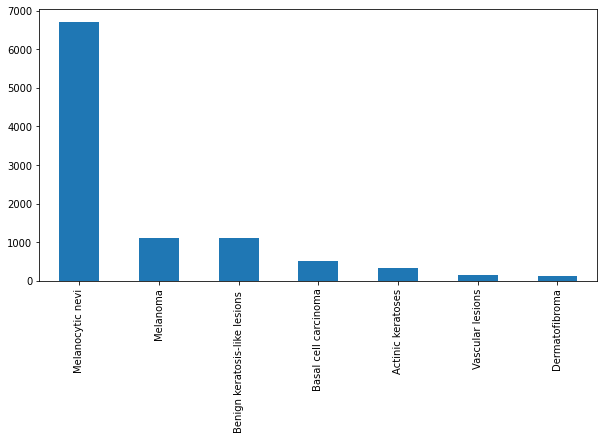

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [9]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((150,100))))

In [10]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(100, 150, 3)    10015
Name: image, dtype: int64

In [11]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [12]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)

In [13]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [14]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [15]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

In [16]:
x_train = x_train.reshape(x_train.shape[0], *(100, 150, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 150, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 150, 3))

In [17]:
input_shape = (100, 150, 3)
num_classes = 7

In [18]:
 from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet50 import ResNet50
# from keras.applications.vgg19 import VGG19
# from keras.applications.mobilenet import MobileNet
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.xception import Xception

# # create the base pre-trained model

In [19]:
base_model = InceptionV3(weights="imagenet", include_top=False , input_shape=(100, 150, 3))

83689472/83683744 [==============================] - 7s 0us/step


In [20]:
from keras.models import Sequential , Model

In [21]:
from keras.layers import Dropout , GlobalAveragePooling2D
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [23]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [26]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [27]:
epochs = 50
batch_size = 32

history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)


Epoch 1/50
225/225 [==============================] - 69s 307ms/step - loss: 1.0431 - accuracy: 0.6344 - val_loss: 0.9404 - val_accuracy: 0.6359
Epoch 2/50
225/225 [==============================] - 46s 205ms/step - loss: 0.8045 - accuracy: 0.7027 - val_loss: 1.4229 - val_accuracy: 0.3429
Epoch 3/50
225/225 [==============================] - 47s 210ms/step - loss: 0.7186 - accuracy: 0.7419 - val_loss: 0.7441 - val_accuracy: 0.7394
Epoch 4/50
225/225 [==============================] - 47s 210ms/step - loss: 0.7636 - accuracy: 0.7140 - val_loss: 1.8031 - val_accuracy: 0.3105
Epoch 5/50
225/225 [==============================] - 47s 209ms/step - loss: 0.7596 - accuracy: 0.7112 - val_loss: 0.7270 - val_accuracy: 0.7145
Epoch 6/50
225/225 [==============================] - 47s 207ms/step - loss: 0.7276 - accuracy: 0.7264 - val_loss: 0.7462 - val_accuracy: 0.7195

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
225/225 [=============================

In [29]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

802/802 [==============================] - 1s 2ms/step
Validation: accuracy = 0.811721  ;  loss_v = 0.669623
Test: accuracy = 0.822766  ;  loss = 0.622511


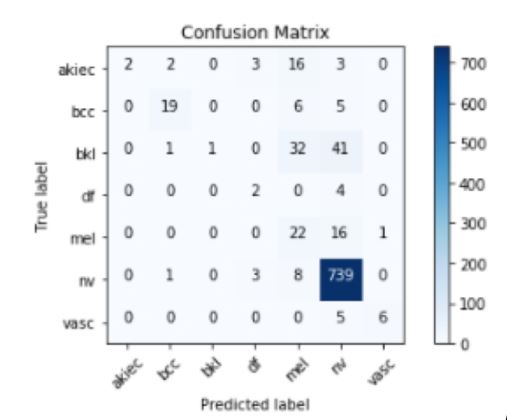

In [1]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

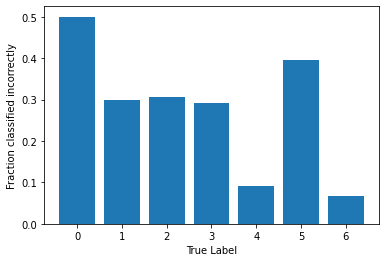

In [31]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

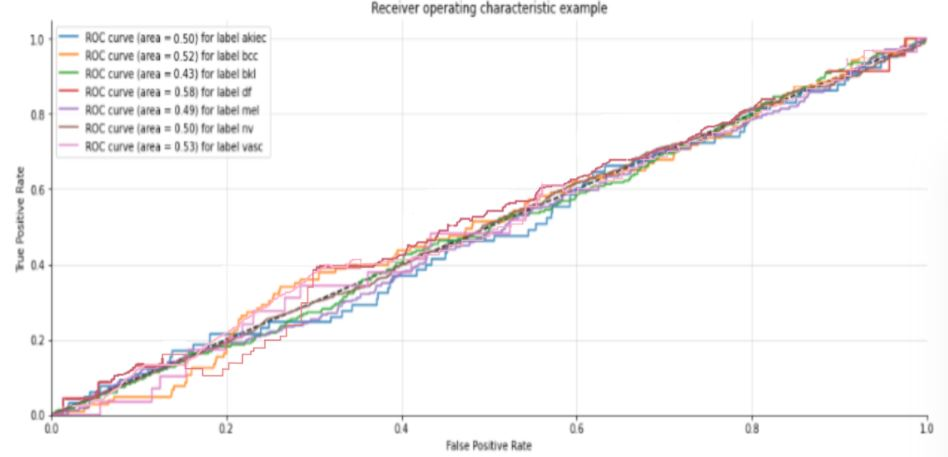

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pandas as pd
# calculate roc curve
test_labels2=test_labels[:-17]
# structures
fpr = dict()
tpr = dict()
roc_auc = dict()
# calculate dummies once
y_test_dummies = pd.get_dummies(test_labels1, drop_first=False).values
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# roc for each class
fig, ax = plt.subplots(figsize=(17,6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
for i in range(7):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i],cm_plot_labels[i]))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()